# Assembly of system with multiple domains, variables and numerics

This tutorial demonstrates how a transient problem may be solved in PorePy. 
We consider the advective-diffusive tracer transport problem for a slightly compressible flow field described in the darcy_and_transport_equations.ipynb tutorial.
The geometry and flow parameters are as in example 2 of this [benchmark study](https://www.sciencedirect.com/science/article/pii/S0309170817300143).

We start by importing modules:

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import data.flow_benchmark_2d_geiger_setup as setup

## Transport parameters
The following parameters are added to the data dictionaries:
* Heat capacity
* (Normal) thermal conductivity
* Boundary conditions, both type and values
* Darcy flux, needed for initial discretization. These values will be computed from the pressure solution to the fluid flow problem as the simulation proceeds.

In [2]:
def add_transport_data(gb, parameter_keyword):
    # Method to assign data.
    tol = 1e-4
    aperture = 1e-4
    kappa_f = 1e-4
    for g, d in gb:
        # Boundary conditions: Dirichlet for left and right side of the domain
        b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:

            b_face_centers = g.face_centers[:, b_faces]
            b_inflow = b_face_centers[0, :] < tol
            b_outflow = b_face_centers[0, :] > 1-tol

            labels = np.array(["neu"] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)

            bc_val[b_faces[b_inflow]] = 1

        else:
            bc = pp.BoundaryCondition(g) #, empty, empty)
        
        # Porosity
        if g.dim == gb.dim_max():
            porosity = 0.2 * unity
        else:
            porosity = 0.8 * unity
        
        specific_volume = np.power(aperture, gb.dim_max() - g.dim)
        
        diffusivity = kappa_f * np.ones(g.num_cells)
        tensor = pp.SecondOrderTensor(diffusivity * specific_volume)
        # Inherit the aperture assigned for the flow problem
        specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "mass_weight": porosity * specific_volume,
            "second_order_tensor": tensor,
            }
        pp.initialize_default_data(g, d, parameter_keyword, specified_parameters)
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
        
    for e, d in gb.edges():
        mg = d["mortar_grid"]
        specific_volume_h = np.power(1e-4, gb.dim_max() - (mg.dim + 1))
        diffusivity_n = kappa_f / (aperture / 2) * specific_volume_h 
        parameters = {
            "normal_diffusivity": diffusivity_n,
            "darcy_flux": np.zeros(mg.num_cells),
        }
        pp.initialize_data(g, d, parameter_keyword, parameters)


We start by making a grid bucket, pecifying the keywords for the parameters of the flow and transport problem, respectively. Then we assigne the problem data and visualize the domain.

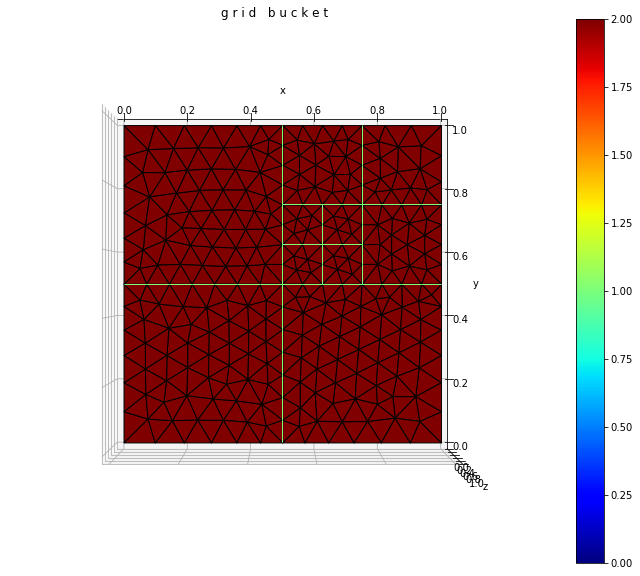

In [3]:
mesh_args = {"mesh_size_frac": .08, "mesh_size_bound": .12}
gb, domain = pp.grid_buckets_2d.benchmark_regular(mesh_args)
fracture_permeability = 1e4
kw_f = 'flow'
kw_t = 'transport'
# Add data - will only add flow data
setup.add_data(gb, domain, fracture_permeability)
        
# Transport related parameters 
add_transport_data(gb, kw_t)
pp.plot_grid(gb, "dimension", figsize=(12, 10))

## Variable definition and initialization
Now, we define the variables on subdomains and interfaces and populate the `STATE` and `ITERATE` dictionaries with initial values.

In [4]:
subdomain_pressure_variable = "pressure"
subdomain_tracer_variable = "tracer"
interface_flux_variable = "interface_flux"
interface_advection_variable = "interface_advection"
interface_conduction_variable = "interface_conduction"
# Loop over the nodes in the GridBucket, define primary variables and discretization schemes
for g, d in gb:
    d[pp.PRIMARY_VARIABLES] = {subdomain_pressure_variable: {"cells": 1, "faces": 0},
                               subdomain_tracer_variable: {"cells": 1, "faces": 0}}
    vals = {
        subdomain_pressure_variable: np.zeros(g.num_cells),
        subdomain_tracer_variable: np.zeros(g.num_cells),
    }
    d[pp.STATE] = vals
    d[pp.STATE][pp.ITERATE] = vals.copy()
    
# Loop over the edges in the GridBucket, define primary variables and discretizations
for e, d in gb.edges():
    mg = d["mortar_grid"]
    d[pp.PRIMARY_VARIABLES] = {interface_flux_variable: {"cells": 1},
                              interface_advection_variable: {"cells": 1},
                              interface_conduction_variable: {"cells": 1},
                              }
    vals = {
        interface_flux_variable: np.zeros(mg.num_cells),
        interface_advection_variable: np.zeros(mg.num_cells),
        interface_conduction_variable: np.zeros(mg.num_cells),
    }
    d[pp.STATE] = vals
    d[pp.STATE][pp.ITERATE] = vals.copy()



 ## Define AD objects
We make a `DofManager` and an `EquationManager` responsible for global degree-of-freedom handling and equation discretization and assembly, respectively. Then, we define discretizations, AD parameters and variables.

In [5]:
dof_manager = pp.DofManager(gb)
eq_manager = pp.ad.EquationManager(gb, dof_manager)

# Ad geometry
subdomain_list = [g for g, _ in gb.nodes()]
interface_list = [e for e, d in gb.edges()]
subdomain_proj = pp.ad.SubdomainProjections(subdomain_list)
mortar_proj = pp.ad.MortarProjections(
            edges=interface_list, grids=subdomain_list, gb=gb, nd=1
        )
# Ad discretization objects
flow = pp.ad.TpfaAd(kw_f, subdomain_list)
conduction = pp.ad.TpfaAd(kw_t, subdomain_list)
advection = pp.ad.UpwindAd(kw_t, subdomain_list)
accumulation_f = pp.ad.MassMatrixAd(kw_f, subdomain_list)
accumulation_t = pp.ad.MassMatrixAd(kw_t, subdomain_list)

interface_flow = pp.ad.RobinCouplingAd(kw_f, interface_list)
interface_advection = pp.ad.UpwindCouplingAd(kw_t, interface_list)
interface_conduction = pp.ad.RobinCouplingAd(kw_t, interface_list)

#Operators
div = pp.ad.Divergence(grids=subdomain_list)
trace = pp.ad.Trace(grids=subdomain_list)

# Parameters
dt = 5e-2
bc_val_f = pp.ad.BoundaryCondition(kw_f, subdomain_list)
bc_val_t = pp.ad.BoundaryCondition(kw_t, subdomain_list)
source_f = pp.ad.ParameterArray(
            param_keyword=kw_f,
            array_keyword="source",
            grids=subdomain_list,
        )
source_t = pp.ad.ParameterArray(
            param_keyword=kw_t,
            array_keyword="source",
            grids=subdomain_list,
        )

# Ad variables
p = eq_manager.merge_variables(
    [(g, subdomain_pressure_variable) for g in subdomain_list]
)
p_prev = p.previous_timestep()
interface_flux = eq_manager.merge_variables(
    [(e, interface_flux_variable) for e in interface_list]
)
t = eq_manager.merge_variables(
    [(g, subdomain_tracer_variable) for g in subdomain_list]
)
t_prev = t.previous_timestep()
advective_interface_flux = eq_manager.merge_variables(
    [(e, interface_advection_variable) for e in interface_list]
)
conductive_interface_flux = eq_manager.merge_variables(
        [(e, interface_conduction_variable) for e in interface_list]
    )


c:\users\ivar\onedrive - university of bergen\documents\github\porepy\src\porepy\grids\mortar_grid.py:663: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  warnings.warn(


## Define flow equation
There is one equation on all subdomains with three terms (fluxes, source/sink and accumulation), while there is one flux relation on the interfaces.

In [6]:
flux = (
    flow.flux * p
    + flow.bound_flux * bc_val_f
    + flow.bound_flux * mortar_proj.mortar_to_primary_int * interface_flux
)
# Optionally, each term may be given a name. This can be highly useful for debugging!
flux.set_name("darcy flux")
subdomain_flow_eq = (
    accumulation_f.mass * (p - p_prev) / dt +
    div * flux 
    - mortar_proj.mortar_to_secondary_int * interface_flux
    - source_f
)

## Interface equation
# Reconstruct primary/higher-dimensional pressure on internal boundaries
p_primary = (
    flow.bound_pressure_cell * p
    + flow.bound_pressure_face
    * mortar_proj.mortar_to_primary_int
    * interface_flux
    + flow.bound_pressure_face * bc_val_f
)
# Project the two pressures to the interface and equate with the interface flux
interface_flow_eq = (
    interface_flow.mortar_discr
    * (
        mortar_proj.primary_to_mortar_avg * p_primary
        - mortar_proj.secondary_to_mortar_avg * p
    )
    + interface_flux
)

## Define transport equation
There is one equation on all subdomains with four terms (conductive fluxes, advective fluxes, source/sink and accumulation). On the interfaces, there are two flux equations (conduction and advection).

A few notes on the advective discretization:
* Upwind discretization of advective flux. 
* Dirichlet and Neumann boundary conditions are handled separately. This is needed since Dirichlet values naturally need multiplication with the flux value (the tracer concentration on the boundary is specified), while Neumann values are interpreted as specifying the product between the flux and the conserved quantity.
* The advective interface flux corresponding to an internal Neumann condition, the bound_transport_neu discretization is used for that term.
* No weight is applied, i.e. c_w is assumed to equal 1.

In [7]:
# Conduction is a direct analogy to fluid flux
conductive_flux = (
    conduction.flux * t
    + conduction.bound_flux * bc_val_t
    + conduction.bound_flux * mortar_proj.mortar_to_primary_int * conductive_interface_flux
) 

advective_flux = (
    flux * ( advection.upwind *  t )
    - advection.bound_transport_dir * flux * bc_val_t
    - advection.bound_transport_neu * (
        mortar_proj.mortar_to_primary_int * advective_interface_flux
    + bc_val_t)
)

accumulation_term = (
    accumulation_t.mass * (t - t_prev) 
) / dt
subdomain_transport_eq = (
    accumulation_term
    + div * (conductive_flux + advective_flux)
    - mortar_proj.mortar_to_secondary_int * conductive_interface_flux
    - mortar_proj.mortar_to_secondary_int * advective_interface_flux
    - source_t
)


### Interface fluxes

In [8]:
# Again, direct analogy to fluid flux.
t_primary = (
    conduction.bound_pressure_cell * t
    + conduction.bound_pressure_face
    * mortar_proj.mortar_to_primary_int
    * conductive_interface_flux
    + conduction.bound_pressure_face
    * bc_val_t
)
interface_conduction_eq = (
    interface_conduction.mortar_discr * (
    mortar_proj.primary_to_mortar_avg * t_primary
    - mortar_proj.secondary_to_mortar_avg * t
    )
    + conductive_interface_flux
)

# Relate advective flux to cell centre tracer of the upwind subdomain (cell-wise)
interface_advection_eq = (
    interface_flux
    * (interface_advection.upwind_primary
    * mortar_proj.primary_to_mortar_avg
    * trace.trace
    * t)
    + interface_flux
    * (interface_advection.upwind_secondary
    * mortar_proj.secondary_to_mortar_avg
    * t)
    - advective_interface_flux
)
equations = {
    "Subdomain flow": subdomain_flow_eq,
    "Subdomain transport": subdomain_transport_eq,
    "Interface flow": interface_flow_eq,
    "Interface advection": interface_advection_eq,
    "Interface conduction": interface_conduction_eq,
}
eq_manager.equations.update(equations)

## Solve problem
Discretize, assemble and solve the linear system in a time loop. We also have to update the `STATE` and `ITERATE` and  back-compute the fluid fluxes (which are not primary variables in the primal formulation of the finite volume scheme used) from the pressure solution. 
We plot the tracer distribution at each time step and the final pressure. The tracer enters from the right boundary, and is transported more quickly through the fractures than the matrix.

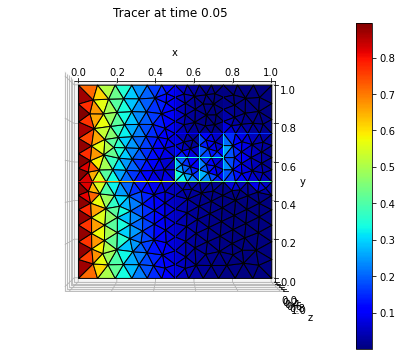

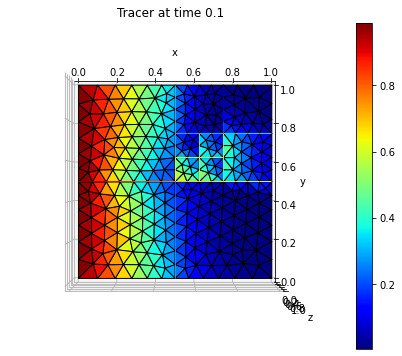

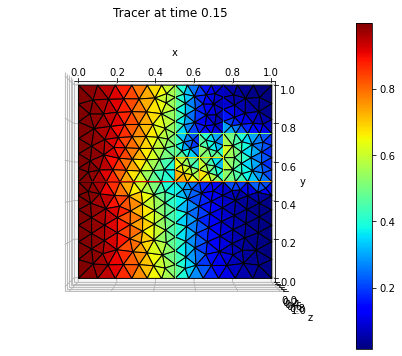

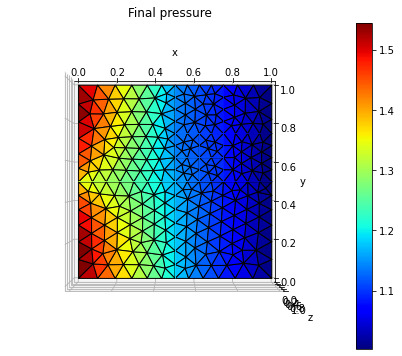

In [9]:
# Discretize all terms
eq_manager.discretize(gb)
time = dt
final_time = 1.5e-1

sol_prev = np.zeros(dof_manager.num_dofs())
nonlinear_tolerance = 1e-10
while time < final_time + 1e-6:
    converged = False
    while not converged:
        # Rediscretize advection based on previous iterate of darcy_flux
        # in case flow field is transient
        pp.fvutils.compute_darcy_flux(gb, 
                                      keyword_store=kw_t,
                                      lam_name=interface_flux_variable,
                                      from_iterate=True)
        # More targeted approaches are possible:
        eq_manager.discretize(gb)
        
        # Iteration
        A, b = eq_manager.assemble()
        sol = sps.linalg.spsolve(A, b)
        error = np.linalg.norm(sol, np.inf)
        sol_prev = sol.copy()
        dof_manager.distribute_variable(
            values=sol, additive=True, to_iterate=True
        )
        if error < nonlinear_tolerance:
            converged = True        
            
    solution = dof_manager.assemble_variable(from_iterate=True)
    dof_manager.distribute_variable(values=solution, additive=False)
    pp.plot_grid(gb, subdomain_tracer_variable, figsize=(8, 6), title=f"Tracer at time {time:.2}")
    time += dt


pp.plot_grid(gb, subdomain_pressure_variable, figsize=(8, 6), title="Final pressure")
